In [1]:
### Predictions from the model

In [9]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [10]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [12]:
cfg.MODEL.DEVICE

'cuda'

In [13]:
import torch
torch.cuda.is_available()

True

In [14]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/21 14:49:14 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [15]:
from detectron2.utils.visualizer import ColorMode

In [16]:
import matplotlib.pyplot as plt

from skimage.io import imshow, imread
from skimage.color import rgb2hsv, hsv2rgb

/root/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
import json
  
# Opening JSON file
f = open('/root/labelstudio/result.json')
  
dataset_dicts = json.load(f)

dataset_dicts.keys()


dict_keys(['images', 'categories', 'annotations', 'info'])

In [18]:
def get_box(im):
    outputs = predictor(im)
    max_index = outputs['instances'].scores.tolist().index(max(outputs['instances'].scores.tolist()))
    x1 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][0]
    y1 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][1]
    x2 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][2]
    y2 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][3]
    #imshow(im[int(y1):int(y2),int(x1):int(x2),:])
    return im[int(y1):int(y2),int(x1):int(x2),:]

In [19]:
def mask_to_rect(mask):
    nmpy_mask = np.array(mask)
    nmpy_mask = nmpy_mask.reshape(nmpy_mask.shape[1],nmpy_mask.shape[2])
    coordinates = np.argwhere(nmpy_mask)
    rect = cv2.minAreaRect(coordinates) # basically you can feed this rect into your classifier
    (x,y),(w,h), a = rect 
    #print(rect)
    return min(w,h)
    

/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 1.31 s, sys: 634 ms, total: 1.94 s
Wall time: 1.12 s


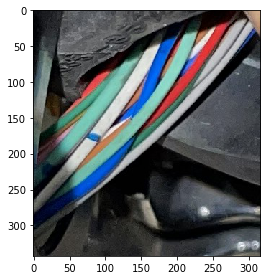

In [20]:
%%time
#-- 5-10 seconds ## Loading to prediction to output

im = imread("/root/labelstudio/images/"+dataset_dicts['images'][1]['file_name'])
imshow(get_box(im))

In [21]:
# def mask_to_rect(mask):
#     coordinates = np.argwhere(mask)
#     rect = cv2.minAreaRect(coordinates) # basically you can feed this rect into your classifier
#     (x,y),(w,h), a = rect 
#     #print(rect)
#     return min(w,h)
    

In [22]:
# mask = predictor(im)['instances'].pred_masks.tolist()
# mask_to_rect(mask)

In [23]:
# rect = cv2.minAreaRect(coordinates) # basically you can feed this rect into your classifier
# (x,y),(w,h), a = rect # a - angle

# box = cv2.boxPoints(rect)
# box = np.int0(box) #turn into ints
# rect2 = cv2.drawContours(im.copy(),[box[:,-1::-1]],0,(0,0,255),10)

# plt.imshow(rect2)
# plt.show()


In [24]:
def get_region(im):
    outputs = predictor(im)
    max_index = outputs['instances'].scores.tolist().index(max(outputs['instances'].scores.tolist()))
    mask = outputs['instances'].pred_masks.tolist()
    bndl_width = mask_to_rect(mask)    
    bundle_area = np.array(mask).reshape(im.shape[0],im.shape[1],1).sum()
    mask = np.array(mask).reshape(im.shape[0],im.shape[1],1)*im
    x1 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][0] 
    y1 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][1]
    x2 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][2]
    y2 = outputs['instances'].pred_boxes.tensor.tolist()[max_index][3]
    #imshow(mask[int(y1):int(y2),int(x1):int(x2),:])
    print(y2,y1,x2,x1,(y2-y1)*(x2-x1))
    return mask[int(y1):int(y2),int(x1):int(x2),:], bundle_area, bndl_width

In [25]:
im1 = get_region(im)

2511.053955078125 2168.43701171875 1346.9364013671875 1029.177001953125 108869.75415095687


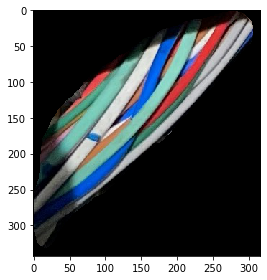

In [26]:
imshow(im1[0])

/root/anaconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


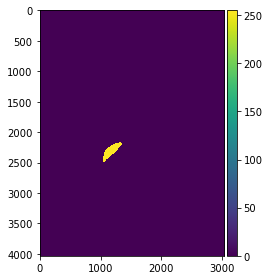

In [27]:
imshow(np.array(predictor(im)['instances'].pred_masks.tolist()).reshape(im.shape[0],im.shape[1])*255)

In [28]:
## Post Processing

In [29]:
def light_level(img,thres = 60):
    r,g,b,_ = cv2.mean(img)
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    if gray <= 60:
        return "dark"
    else :
        return "okay light"

def change_brightness(img, value=60):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img



def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def is_blurry(image, threshold = 80):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    fm = variance_of_laplacian(gray)
    text = "Not Blurry"
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < threshold:
        text = "Blurry"
    return [text, round(fm,2)]

In [30]:
im1 = get_box(im)
mask_im,bundle_area,bndl_width = get_region(im)

2511.053955078125 2168.43701171875 1346.9364013671875 1029.177001953125 108869.75415095687


In [31]:
original = im1.copy()
image = cv2.cvtColor(im1, cv2.COLOR_RGB2HSV)
lower = np.array([20, 60, 60], dtype="uint8")
upper = np.array([30, 255, 255], dtype="uint8")
mask = cv2.inRange(image, lower, upper)
cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#yellow':upper: [[35, 255, 255],lower : [25, 50, 70]]

In [100]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import cv2

import matplotlib.pyplot as plt

def plot_graph(X,Y, slopes,constants):
    plt.plot(X,Y,"go")
    #plt.xlim(0,500)
    #plt.ylim(0,500)
    plt.xlim(int(X.min()-20), int(X.max()+20))
    plt.ylim(int(Y.min()-20), int(Y.max()+20))

    def abline(slope, intercept):
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--')

    abline(float(slopes[0]),float(constants[0]))
    abline(float(slopes[0]),float(constants[2]))
    abline(float(slopes[1]),float(constants[1]))
    abline(float(slopes[1]),float(constants[3]))  
    plt.show()

def is_between(slopes,constants,points):
    Y = points[:,1]
    X = points[:,0]
    a = torch.cat((Y - slopes*X, Y - slopes*X), 0) - constants
    check = (a[0]*a[2]<=0)*(a[1]*a[3]<=0)
    between = torch.sum(check)
    total = check.size(dim=0)
    ratio = between/total
    return ratio

#points = torch.tensor([[0,2],[2,0],[0.5,1.5],[1,1],[2,2],[3,3],[3,0.8],[2.5,3.5],[2,4],[3,1.5],[0,2.3],[1.5,3],[1,3]])

def get_rect(cnt):
    
    points = []
    
    for i in cnt:
        points.append([i[0][0],i[0][1]])
    points = torch.tensor(points)

    Y = points[:,1]
    X = points[:,0]
    
    learning_rate = 0.01

    epochs = 1000
    n = X.shape[0]

    import cv2
    import numpy as np
    

    rect = cv2.minAreaRect(np.array(points))
    m = np.tan(np.pi*rect[2]/180)
    slope = torch.tensor([[m]],requires_grad=True)
    box = cv2.boxPoints(rect)

    c0 = box[0][1] - (m*box[0][0])
    c1 = box[0][1] + (box[0][0]/m)
    c2 = box[2][1] - (m* box[2][0])
    c3 = box[2][1] + (box[2][0]/m)

    constants = torch.tensor([[c0],[c1],[c2],[c3]],requires_grad=True)
    # slope = torch.rand([1,1],requires_grad=True)
    # constants = torch.rand([4,1],requires_grad=True)
    
    #print(slope,constants)
    for i in range(epochs):

        slopes = torch.cat((slope,-1/slope) ,0)
        num  = abs(torch.cat((Y - slopes*X, Y - slopes*X), 0) - constants)
        den = torch.cat((torch.sqrt(1 + slopes*slopes), torch.sqrt(1 + slopes*slopes)), 0)
        distances = num/den
        dists_min = torch.amin(distances,0).sum()/n
        dists_min.backward()

#         if i % 1000 == 0:
#             print(i) 

#         if i%1000==0:
#             plot_graph(X,Y, slopes,constants)

        with torch.no_grad():
            slope -= learning_rate * slope.grad
            constants -= learning_rate *10* constants.grad

            slope.grad.zero_()
            constants.grad.zero_()
            
    plot_graph(X,Y, slopes,constants)
    dist =  is_between(slopes,constants,points)
    
    if dist >=0.65:
        return(float(abs(constants[0]-constants[2])/torch.sqrt(1+slopes[0]**2)), float(abs(constants[1]-constants[3])/torch.sqrt(1+slopes[1]**2)))
    else :
        return rect[1]

2561.950439453125 2327.163330078125 1195.7205810546875 904.9489135742188 68269.43929588795


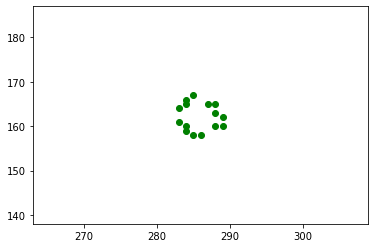

tensor(0) 15


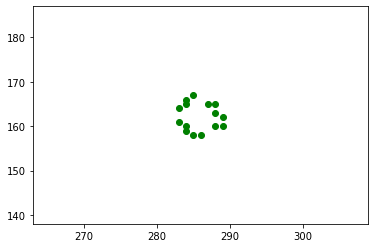

tensor(0) 15
0.0007719405062190137 (6.260990142822266, 8.497057914733887)


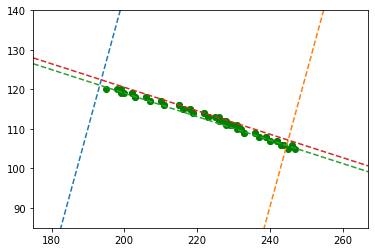

tensor(41) 59


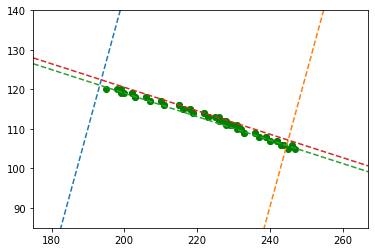

tensor(41) 59
0.00013046881795250934 (53.578530744789376, 1.4161020032316942)


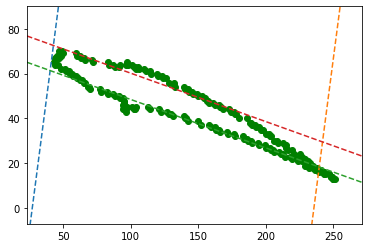

tensor(111) 219


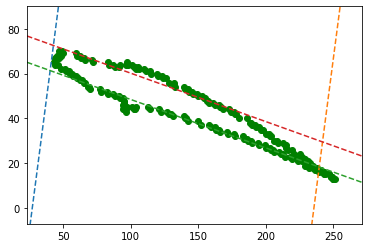

tensor(111) 219
0.04383752283204314 (21.674543380737305, 214.35191345214844)


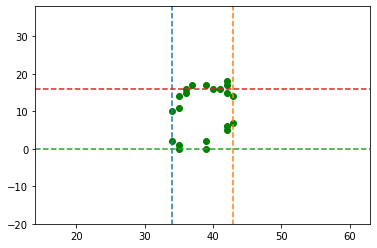

tensor(15) 21


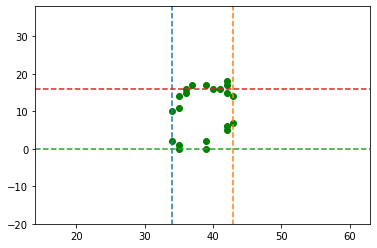

tensor(15) 21
0.0026202487605462297 (9.000000000000004, 15.995238095236997)


KeyboardInterrupt: 

In [101]:
# canvas = np.zeros(image.shape,np.uint8)
# canvas.fill(255)
# num_cnts =0
# ctr_lines = []

for j in dataset_dicts['images']:
    
    im = imread("/root/labelstudio/images/"+j['file_name'])

    im1 = get_box(im)
    mask_im,bundle_area,bndl_width = get_region(im)

    original = im1.copy()
    image = cv2.cvtColor(im1, cv2.COLOR_RGB2HSV)
    lower = np.array([20, 60, 60], dtype="uint8")
    upper = np.array([30, 255, 255], dtype="uint8")
    mask = cv2.inRange(image, lower, upper)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for a,c in enumerate(cnts):
        ratio = cv2.contourArea(c)/bundle_area
        #print(ratio)
        if ratio >= 0.0001:
            a = get_rect(c)
            print(ratio,get_rect(c))


In [ ]:
# points = []
# for i in cnts[58]:
#     points.append([i[0][0],i[0][1]])
# points = torch.tensor(points)
# #points

In [66]:
((a[2][0]*a[2][2]>=0)*(a[2][1]*a[2][3]>=0)).size(dim=0)

21

In [28]:
# points = torch.tensor(points)

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import cv2

import matplotlib.pyplot as plt

def plot_graph(X,Y, slopes,constants):
    plt.plot(X,Y,"go")
    plt.xlim(int(X.min()-20), int(X.max()+20))
    plt.ylim(int(Y.min()-20), int(Y.max()+20))

    def abline(slope, intercept):
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--')

    abline(float(slopes[0]),float(constants[0]))
    abline(float(slopes[0]),float(constants[2]))
    abline(float(slopes[1]),float(constants[1]))
    abline(float(slopes[1]),float(constants[3]))  
    plt.show()

#points = torch.tensor([[0,2],[2,0],[0.5,1.5],[1,1],[2,2],[3,3],[3,0.8],[2.5,3.5],[2,4],[3,1.5],[0,2.3],[1.5,3],[1,3]])

def get_rect(cnt):
    
    points = []
    
    for i in cnt:
        points.append([i[0][0],i[0][1]])
    points = torch.tensor(points)

    Y = points[:,1]
    X = points[:,0]
    
    learning_rate = 0.01

    epochs = 10000
    n = X.shape[0]

    import cv2
    import numpy as np

    rect = cv2.minAreaRect(np.array(points))
    m = np.tan(np.pi*rect[2]/180)
    slope = torch.tensor([[m]],requires_grad=True)
    box = cv2.boxPoints(rect)

    c0 = box[0][1] - (m*box[0][0])
    c1 = box[0][1] + (box[0][0]/m)
    c2 = box[2][1] - (m* box[2][0])
    c3 = box[2][1] + (box[2][0]/m)

    constants = torch.tensor([[c0],[c1],[c2],[c3]],requires_grad=True)
    # slope = torch.rand([1,1],requires_grad=True)
    # constants = torch.rand([4,1],requires_grad=True)

    for i in range(epochs):

        slopes = torch.cat((slope,-1/slope) ,0)
        num  = abs(torch.cat((Y - slopes*X, Y - slopes*X), 0) - constants)
        den = torch.cat((torch.sqrt(1 + slopes*slopes), torch.sqrt(1 + slopes*slopes)), 0)
        distances = num/den
        dists_min = torch.amin(distances,0).sum()/n
        dists_min.backward()

#         if i % 1000 == 0:
#             print(i) 

#         if i%1000==0:
#             plot_graph(X,Y, slopes,constants)

        with torch.no_grad():
            slope -= learning_rate * slope.grad
            constants -= learning_rate *10* constants.grad

            slope.grad.zero_()
            constants.grad.zero_()
            
    plot_graph(X,Y, slopes,constants)
    return(float(abs(constants[0]-constants[2])/torch.sqrt(1+slopes[0]**2)), float(abs(constants[1]-constants[3])/torch.sqrt(1+slopes[1]**2)))

In [30]:
from sklearn.linear_model import LinearRegression
def count_yellow_wires(im1,blur,bundle_area,bndl_width,area_threshold,erosion_dialation):
    
    original = im1.copy()
    image = cv2.cvtColor(im1, cv2.COLOR_RGB2HSV)
    lower = np.array([20, 60, 60], dtype="uint8")
    upper = np.array([30, 255, 255], dtype="uint8")
    mask = cv2.inRange(image, lower, upper)
    
    
    if erosion_dialation:
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.erode(mask, kernel, iterations=1)
        mask = cv2.dilate(mask, kernel, iterations=1)

    
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    
#      def fit_line(c):
#         [vx,vy,x,y] = cv2.fitLine(c, cv.DIST_L2,0,0.01,0.01)
#         m = vy/vx
#         c = y - (m*x)
#         return (m,c,(c[:,:,0].mean(),c[:,:,1].mean()))
       
    def fit_line(c):
    
        model = LinearRegression()
        model.fit(c[:,:,0],[a[0] for a  in c[:,:,1]])
        return [model.coef_[0],model.intercept_,(c[:,:,0].mean(),c[:,:,1].mean())]
    
    def get_dist(line1, line2):
        m_avg = (line1[0]+line2[0])/2
        y2 = line2[2][1]
        y1 = line1[2][1]
        x2 = line2[2][0]
        x1 = line1[2][0]

        c2 = y2 - m_avg*x2
        c1 = y1 - m_avg*x1

        return (abs(c2 - c1)/np.sqrt(1 + m_avg**2))
    
    def is_same_line(line1, line2,ang_thres = 6, dist_thres = 10):
    
        if abs(np.rad2deg(line1[0]) - np.rad2deg(line2[0])) < ang_thres:
            if get_dist(line1, line2) < dist_thres:
                return True
        return False
    
    canvas = np.zeros(image.shape,np.uint8)
    canvas.fill(255)
    num_cnts =0
    ctr_lines = []
    for a,c in enumerate(cnts):
        
        ratio = cv2.contourArea(c)/bundle_area 
        if ratio >= area_threshold:
            line = fit_line(c)
            #print(get_rect(c),bndl_width/7)
            if min(get_rect(c)) >= bndl_width/7:
                line = line +[1]
            else:
                line = line + [0]
            num_cnts +=1
            #print(f"num_cnts = {num_cnts}")
            cv2.drawContours(canvas, cnts, a,(0,255,0),2)
            ctr_lines.append(line)
        #if ratio!=0:
            #print(bundle_area,cv2.contourArea(c),ratio)
            

    def count_wires(ctr_lines,ang_thres = 6, dist_thres = 10):
        print(ctr_lines)
        grp_dict = {} 
        for i in ctr_lines:

            for j in grp_dict.keys():
                if is_same_line(i,j,ang_thres, dist_thres):
                    #grp_dict[j] = 
                    grp_dict[tuple(j)].append(tuple(i))
                    #print(f"found {i}:{j}")
                    #print(grp_dict)
                    break


            else :
                grp_dict[tuple(i)] = [tuple(i)]
        #print(grp_dict)
        print(grp_dict)
        num = 0
        for i,j in grp_dict.items():
            check = True
            if i[3] == 1:
                num += 2
                break
            else:
                for m in j:
                    if m[3] == 1:
                        num += 2
                        check = False
                        break
            if check:
                num += 1
          
        return num

    no_wires = count_wires(ctr_lines,15,25)
    
    fig, ax = plt.subplots(1,3, figsize = (12,5))

    ax[0].imshow(im1)
    ax[1].imshow(mask)
    ax[2].imshow(canvas)

    ax[0].set_title(f"original image {blur}")
    ax[1].set_title(f"masked Image - contours : {num_cnts}")
    ax[2].set_title(f"original image wires - {no_wires}")
    
    
    fig.show()
    
    return no_wires

In [31]:
def post_processing(image,mask_img,bundle_area,bndl_width,area_threshold,erosion_dialation):
    
    light_lvl = light_level(image)
    blur = is_blurry(image) + [light_lvl]
    
    if light_lvl == "dark":
        return count_yellow_wires(change_brightness(mask_img),blur[:2],bundle_area,bndl_width,area_threshold,erosion_dialation)
    else :
        return count_yellow_wires(mask_img,blur,bundle_area,bndl_width,area_threshold,erosion_dialation)

In [32]:
im = imread("/root/labelstudio/images/"+dataset_dicts['images'][0]['file_name'])

In [33]:
image = get_box(im)
mask_img,bundle_area,bndl_width = get_region(im)
        

2561.950439453125 2327.163330078125 1195.7205810546875 904.9489135742188 68269.43929588795


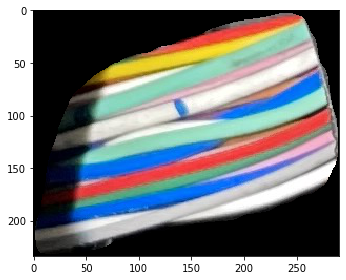

In [34]:
imshow(mask_img)

In [35]:
mask_img.shape

(234, 291, 3)

In [36]:
cv2.mean(im)

(112.19787295222872, 107.25415459393633, 104.0104923672787, 0.0)